In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [2]:
mnist_train = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
trainloader = torch.utils.data.DataLoader(mnist_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(mnist_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(mnist_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [4]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(output), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train Initial Network

In [72]:
net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))

<All keys matched successfully>

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [8]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)

torch.backends.cudnn.deterministic=True

In [9]:
for epoch in range(1, 3):
        # log run every epoch

        train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293168
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.906617
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.209231
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.248116
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.145837
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.199106
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.157115
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.028595
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.017203
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.143006
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.047136
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.029826


In [10]:
torch.save(net.state_dict(), 'models/mnist-before.pt')

# Embedding

In [24]:
net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        logits_train.append(net(data).detach().cpu())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
        data = data.cuda()
        logits_test.append(net(data).detach().cpu())
logits_test = torch.cat(logits_test)

In [13]:
ptsne = ParametricTSNE(10, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

In [14]:
#ptsne.fit(outputs, pretrain=True,verbose=True)
ptsne.fit(logits_train[::12], pretrain=True, verbose=True)

Calculating PCA
2020-02-27 13:07:38.730140: Beginning pretraining for 5 epochs
2020-02-27 13:07:38.837850: Loss after epoch 0: 193.44024920463562
2020-02-27 13:07:38.986454: Loss after epoch 1: 21.83497679233551
2020-02-27 13:07:39.070230: Loss after epoch 2: 9.901884734630585
2020-02-27 13:07:39.151014: Loss after epoch 3: 4.005166664719582
2020-02-27 13:07:39.234789: Loss after epoch 4: 2.040949173271656
2020-02-27 13:07:39.235787: Finished pretraining
Indexing
2020-02-27 13:08:04.376534: Beginning training for 10 epochs
2020-02-27 13:08:04.767005: Loss after epoch 1: 16.877013429293722
2020-02-27 13:08:05.094653: Loss after epoch 2: 15.608637823144552
2020-02-27 13:08:05.414801: Loss after epoch 3: 15.007325775300743
2020-02-27 13:08:05.774519: Loss after epoch 4: 14.61071348406336
2020-02-27 13:08:06.124606: Loss after epoch 5: 14.444974948127967
2020-02-27 13:08:06.444464: Loss after epoch 6: 14.522191466745
2020-02-27 13:08:06.802641: Loss after epoch 7: 14.291001247480734
2020-0

In [15]:
torch.save(ptsne.state_dict(), 'models/mnist-ptsne.pt')

In [25]:
ptsne.eval()
projected_train = ptsne(logits_train.cuda()).detach().cpu()
projected_test = ptsne(logits_test.cuda()).detach().cpu()

# Determine Suitable Shifts

In [18]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

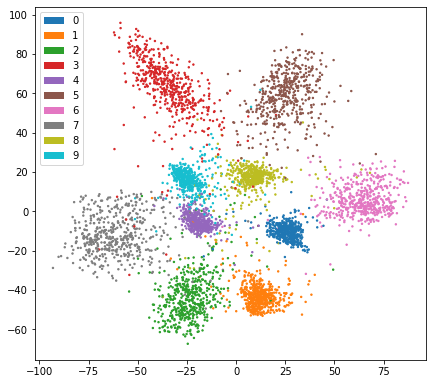

In [124]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [30]:
shift = (mnist_train.targets == 9).float().unsqueeze(1) * torch.tensor([-5.,8.]) + (mnist_train.targets == 4).float().unsqueeze(1) * torch.tensor([8.,0.])
shifted_train = projected_train + shift

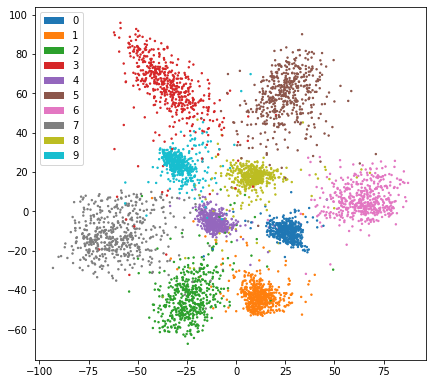

In [125]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [33]:
shifted_dataset = torch.utils.data.TensorDataset(mnist_train.data.unsqueeze(1).float() / 255., shifted_train, mnist_train.targets)
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [114]:
net = Net()
net.load_state_dict(torch.load('models/mnist-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(3):
    train_altered(200, net, 'cuda', shifted_loader, ptsne, optimizer, epoch, 1.)

torch.save(net.state_dict(), 'models/mnist-after.pt')

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.086800
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.559939
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.203345
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.159454
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.114323
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.092854
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.075771
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.045740
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.068864
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.050779
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.058251
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.044584
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073797
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.029139
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.064531
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.043038
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.034171
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.050756


In [115]:
net.eval()
with torch.no_grad():
    new_projected_train = []
    new_logits_train = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        new_logits_train.append(out.detach().cpu())
        new_projected_train.append(ptsne(out).detach().cpu())
new_projected_train = torch.cat(new_projected_train)
new_logits_train = torch.cat(new_logits_train)

In [116]:
net.eval()
with torch.no_grad():
    new_projected_test = []
    new_logits_test = []
    for data, targets in testloader:
        out = net(data.cuda())
        new_logits_test.append(out.detach().cpu())
        new_projected_test.append(ptsne(out).detach().cpu())
new_projected_test = torch.cat(new_projected_test)
new_logits_test = torch.cat(new_logits_test)

# Evaluation

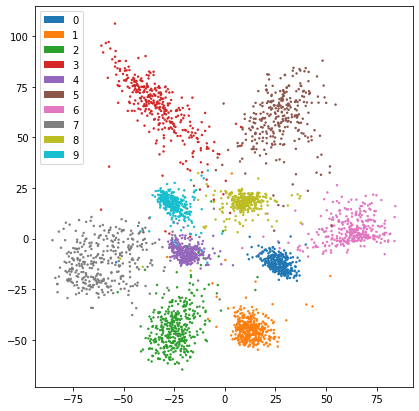

In [92]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(projected_test[::3,0], projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

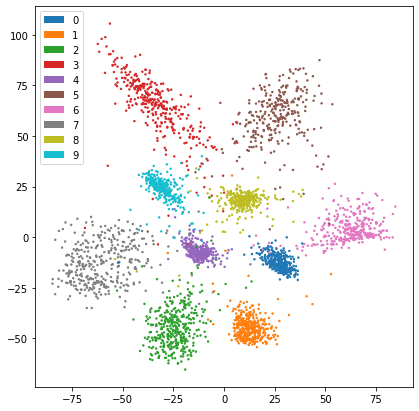

In [93]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist_test.targets[::3]]
ax.scatter(new_projected_test[::3,0], new_projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [117]:
cf_train = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, logits_train.argmax(dim=1)):
    cf_train[i] += 1

cf_test = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, logits_test.argmax(dim=1)):
    cf_test[i] += 1

In [118]:
new_cf_train = torch.zeros(10,10, dtype=int)
for i in zip(mnist_train.targets, new_logits_train.argmax(dim=1)):
    new_cf_train[i] += 1

new_cf_test = torch.zeros(10,10, dtype=int)
for i in zip(mnist_test.targets, new_logits_test.argmax(dim=1)):
    new_cf_test[i] += 1

In [120]:
cf_test.diag().sum().float() / cf_test.sum().float()
# resuming training for 3 more epochs yields 0.9850 to 0.9870

tensor(0.9827)

In [121]:
new_cf_test.diag().sum().float() / new_cf_test.sum().float()

tensor(0.9746)

In [98]:
cf_train

tensor([[5852,    0,    3,    2,    2,    4,   23,    9,   11,   17],
        [   1, 6669,   11,    0,    4,    0,   17,   21,   18,    1],
        [   4,   14, 5827,   16,    2,    0,    3,   45,   43,    4],
        [   2,    4,   17, 6014,    0,   25,    2,   25,   35,    7],
        [   2,    6,    3,    0, 5778,    0,    6,    4,    8,   35],
        [   3,    1,    2,   25,    1, 5303,   41,    5,   23,   17],
        [  11,    0,    2,    0,    7,    6, 5880,    0,   11,    1],
        [   1,    7,   29,    1,    8,    0,    0, 6191,   13,   15],
        [   3,    9,    8,   12,    3,   10,   25,    8, 5766,    7],
        [   4,   10,    0,   16,   28,   10,    0,   45,   61, 5775]])

In [99]:
new_cf_train

tensor([[5895,    0,    3,    2,    2,    5,    6,    4,    2,    4],
        [   2, 6692,    7,    0,    7,    0,    7,   22,    5,    0],
        [   3,    5, 5905,    7,    2,    0,    1,   23,   10,    2],
        [   2,    0,   14, 6066,    0,   17,    1,   16,   12,    3],
        [   3,    3,    1,    0, 5813,    0,    4,    5,    3,   10],
        [   3,    0,    3,   15,    1, 5372,   16,    4,    4,    3],
        [  13,    0,    3,    1,    8,   14, 5873,    0,    6,    0],
        [   1,    7,   17,    1,    1,    0,    0, 6232,    2,    4],
        [   6,   10,   16,   11,    7,   16,   13,   11, 5755,    6],
        [   4,    3,    0,    9,   31,   13,    0,   36,   14, 5839]])

In [122]:
print(cf_test[4,4].float() / cf_test[:,4].sum().float())
print(cf_test[4,4].float() / cf_test[4,:].sum().float())

print(cf_test[9,9].float() / cf_test[:,9].sum().float())
print(cf_test[9,9].float() / cf_test[9,:].sum().float())

tensor(0.9898)
tensor(0.9847)
tensor(0.9808)
tensor(0.9643)


In [123]:
print(new_cf_test[4,4].float() / new_cf_test[:,4].sum().float()) # precision
print(new_cf_test[4,4].float() / new_cf_test[4,:].sum().float()) # recall

print(new_cf_test[9,9].float() / new_cf_test[:,9].sum().float()) # precision
print(new_cf_test[9,9].float() / new_cf_test[9,:].sum().float()) # recall

tensor(0.9967)
tensor(0.9246)
tensor(0.8945)
tensor(0.9911)
